# Import library and sorce codes

## Import library

In [1]:
import pandas as pd
from pymatgen import core
from sklearn.preprocessing import StandardScaler
import torch
import numpy as np
import matplotlib.pyplot as plt


## Import sorce codes

In [2]:
import src.preprocess_func as preprocess
import src.training_model as training
import src.plotting as plotting
import src.Variable_generator as vg

# Preprocess data

In [3]:
# filename = 'https://drive.google.com/uc?id=1-2Ia30pDDiRgof0FFinN4EQ-1BN24qld&export=download'
filename = 'srf/SM_FT_dataset.csv'
df = pd.read_csv(filename,index_col=0)

comps = [core.Composition(x) for x in df['Composition']]
dset = preprocess.data_generator(comps)
Training_sequences = dset.real_data # X_train
Elements_sequences = dset.elements #input elements sequence

properties_values = df.iloc[:,1:].values.astype('float32') # Y_train
scaler = StandardScaler() # Standard_scaler
properties_values_scaled = scaler.fit_transform(properties_values) # Scaled Y_train


# Train models

## Surrogate model

In [4]:
surrogate_model = torch.load("Trained_models/ANN.pth")
cAE = torch.load("Trained_models/cAE.pth")
cVAE = torch.load("Trained_models/cVAE.pth")
WcGAN = torch.load("Trained_models/WcGAN.pth")

In [4]:
# surrogate_model=training.training_surrogate_ANN(Training_sequences,properties_values_scaled)

  0%|          | 0/2000 [00:00<?, ?it/s]

epoch: 100, Loss:1.034603238105774
epoch: 200, Loss:0.8605858683586121
epoch: 300, Loss:0.6730765104293823
epoch: 400, Loss:0.5379103422164917
epoch: 500, Loss:0.3537757694721222
epoch: 600, Loss:0.03589438274502754
epoch: 700, Loss:0.0035208400804549456
epoch: 800, Loss:0.0014910948229953647
epoch: 900, Loss:0.001228710520081222
epoch: 1000, Loss:0.001136333798058331
epoch: 1100, Loss:0.0010813988046720624
epoch: 1200, Loss:0.0010591624304652214
epoch: 1300, Loss:0.0010482191573828459
epoch: 1400, Loss:0.001041767536662519
epoch: 1500, Loss:0.0010378957958891988
epoch: 1600, Loss:0.001033344422467053
epoch: 1700, Loss:0.0010300780413672328
epoch: 1800, Loss:0.0010275269160047174
epoch: 1900, Loss:0.0010248319013044238
epoch: 2000, Loss:0.0010220161639153957
******Training ANN completed*****


In [47]:
# torch.save(surrogate_model,"Trained_models/ANN.pth")

## cAE

In [5]:
# cAE=training.training_cAE(Training_sequences,properties_values_scaled)

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 100, Loss:0.005933467764407396
epoch: 200, Loss:0.0027764185797423124
epoch: 300, Loss:0.001263675861991942
epoch: 400, Loss:0.0008455827482976019
epoch: 500, Loss:0.000631541945040226
epoch: 600, Loss:0.0005111245554871857
epoch: 700, Loss:0.0004343788605183363
epoch: 800, Loss:0.0003667711862362921
epoch: 900, Loss:0.00031952327117323875
epoch: 1000, Loss:0.00027689465787261724
*****Training cAE completed*****


## cVAE

In [6]:
# cVAE=training.training_cVAE(Training_sequences,properties_values_scaled)

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 100, Loss:0.0761018618941307
epoch: 200, Loss:0.022816123440861702
epoch: 300, Loss:0.013504408299922943
epoch: 400, Loss:0.01046915352344513
epoch: 500, Loss:0.008813535794615746
epoch: 600, Loss:0.007640432100743055
epoch: 700, Loss:0.006815834902226925
epoch: 800, Loss:0.006153557915240526
epoch: 900, Loss:0.005654235370457172
epoch: 1000, Loss:0.005279772449284792
*****Training cAE completed*****


## WcGAN

In [21]:
WcGAN = training.WcGAN(dset,properties_values_scaled,surrogate_model)
WcGAN.train(num_iterations=int(4e4),batch_size=520)
WcGAN_accuracy = plotting.visilize_accuracy_GAN(WcGAN.samples_real,WcGAN.samples_fake,scaler)

  0%|          | 0/40000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [19]:
V_GAN_data,V_GAN_conds = vg.preprocess_violinplot_GAN(properties_values,scaler,WcGAN,surrogate_model)
V_GAN = plotting.violin_plot(V_GAN_data,V_GAN_conds)

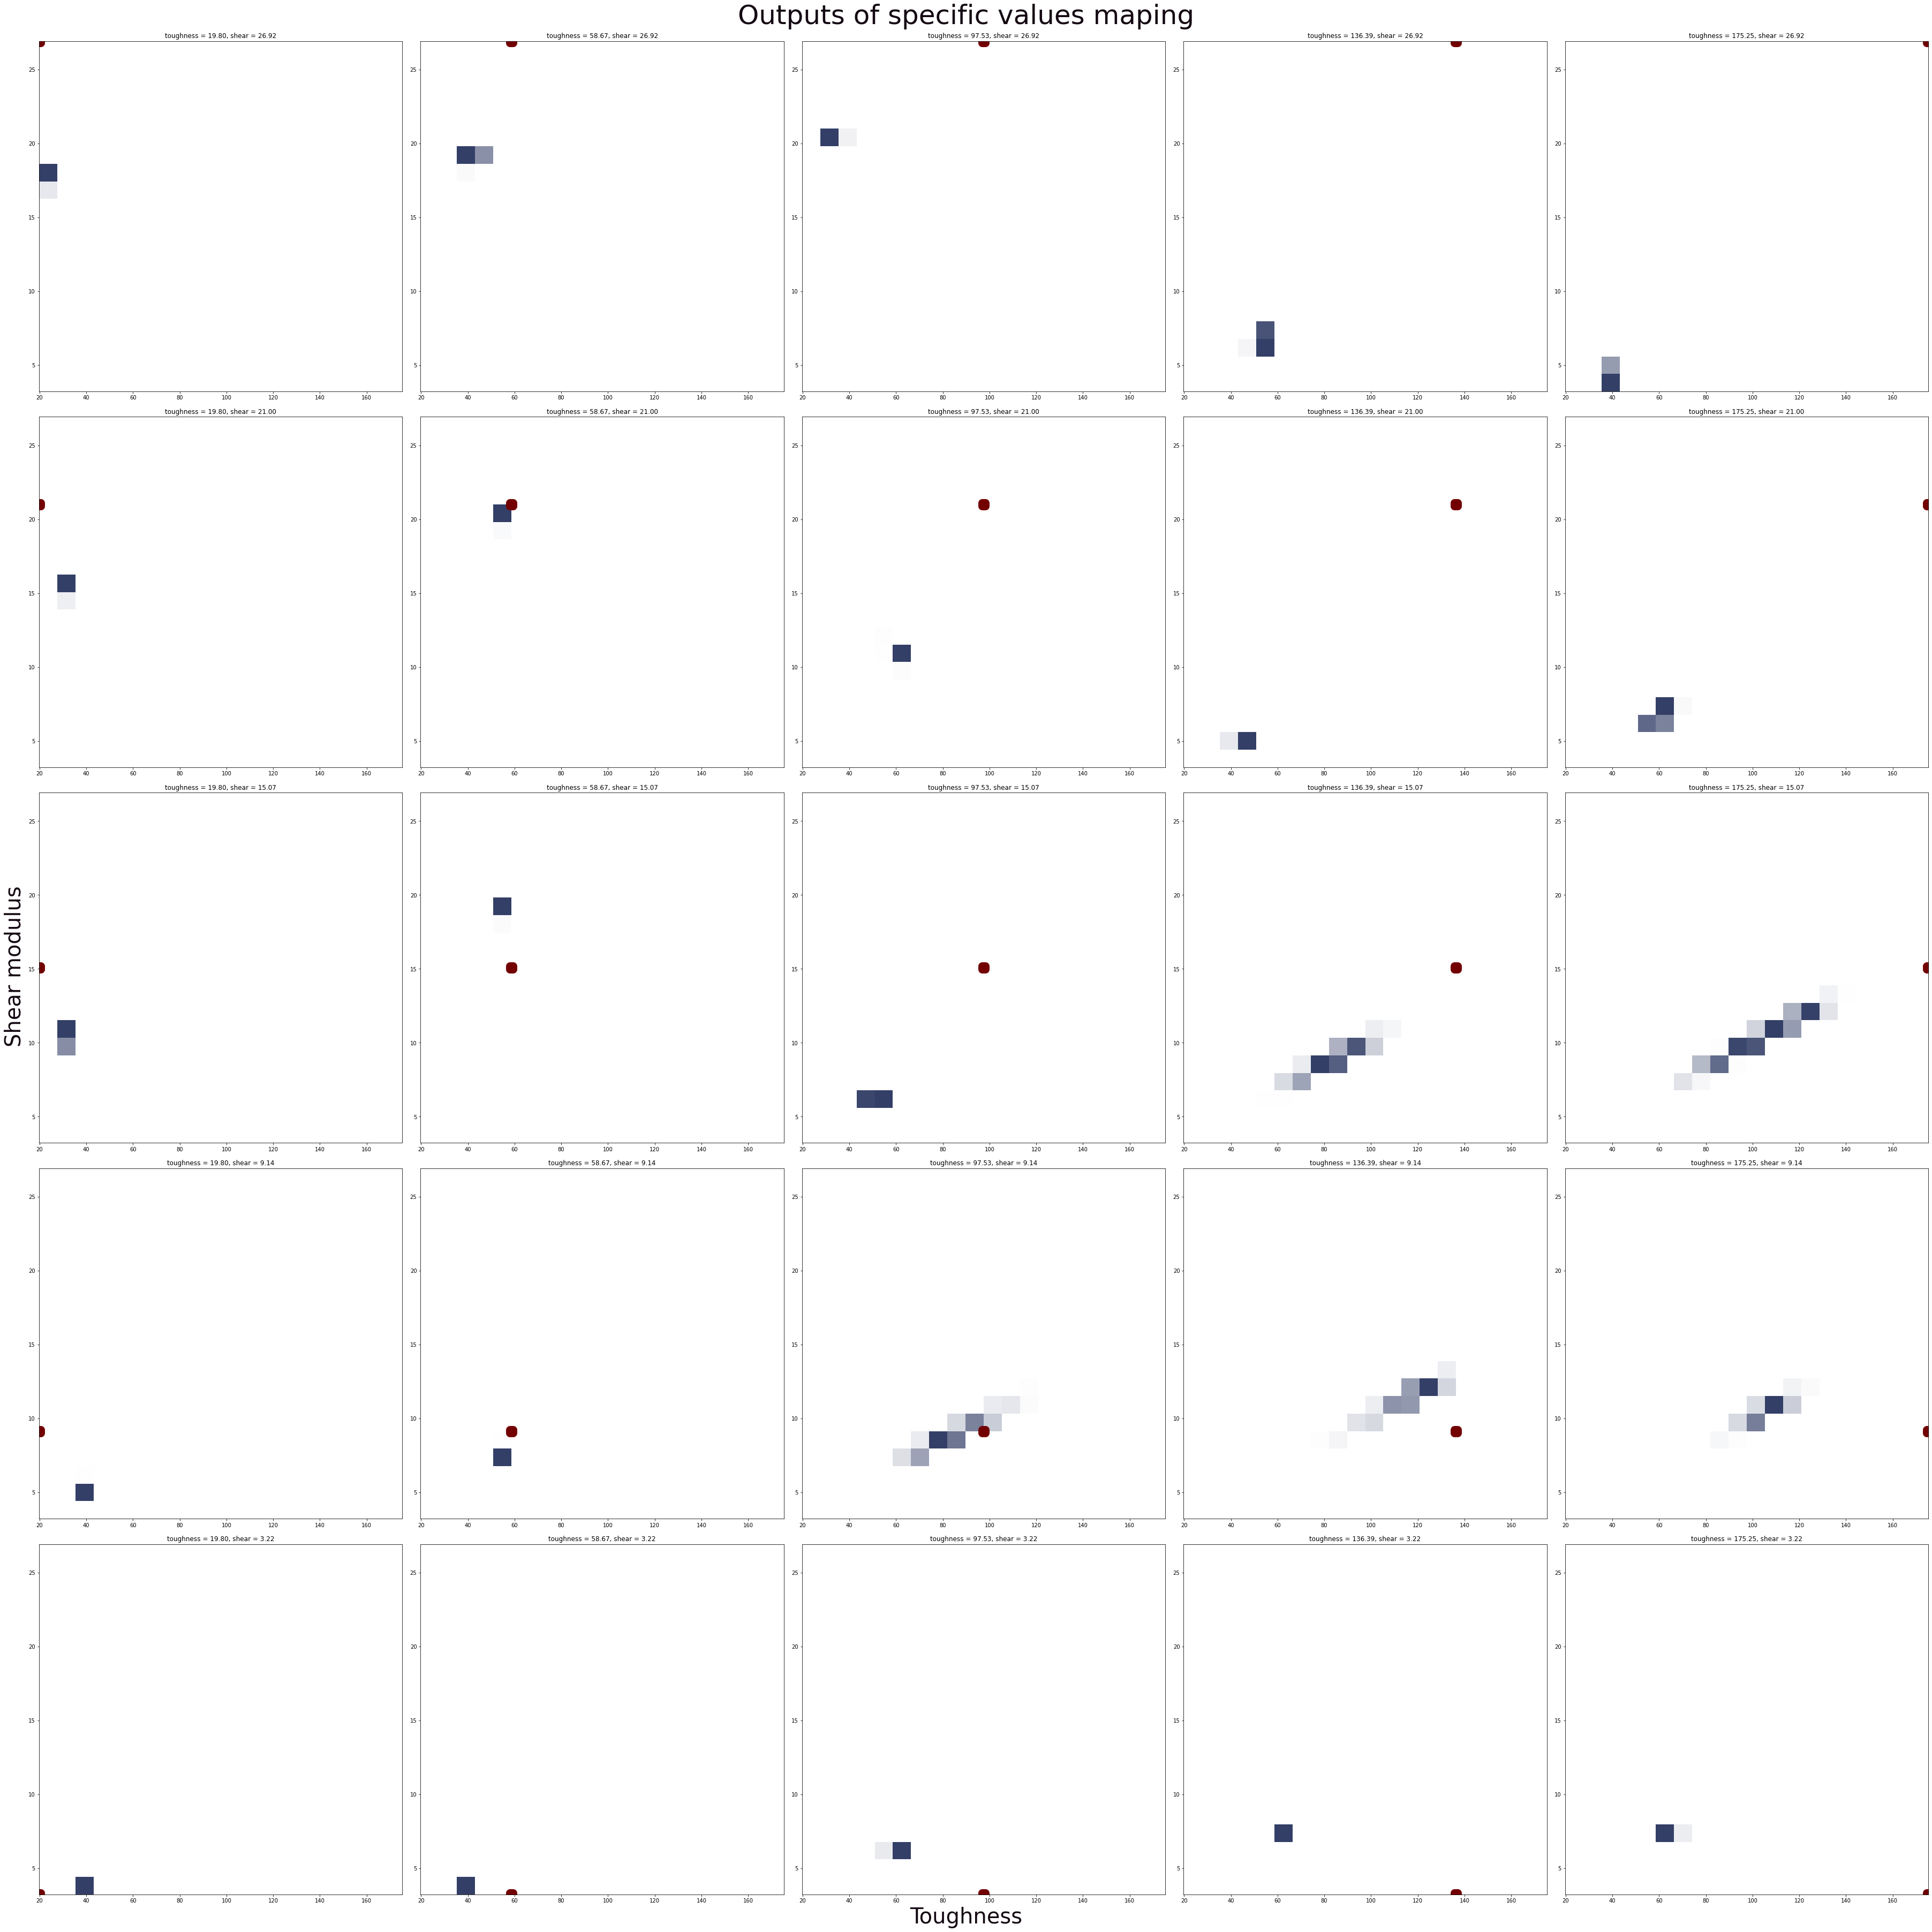

In [20]:
M_GAN_data,M_GAN_conds = vg.preprocess_variance_map_GAN(properties_values,scaler,WcGAN,surrogate_model)
M_GAN = plotting.variance_map(M_GAN_data,M_GAN_conds )

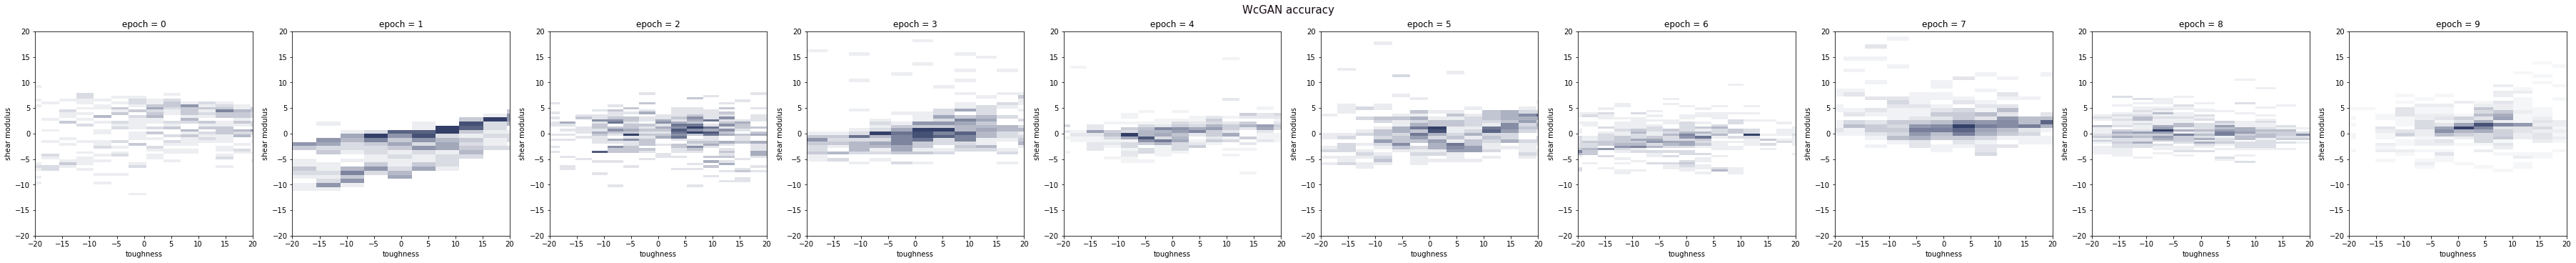

In [12]:
torch.save(WcGAN,"Trained_models/WcGAN.pth")

# Plot

## Input dataset

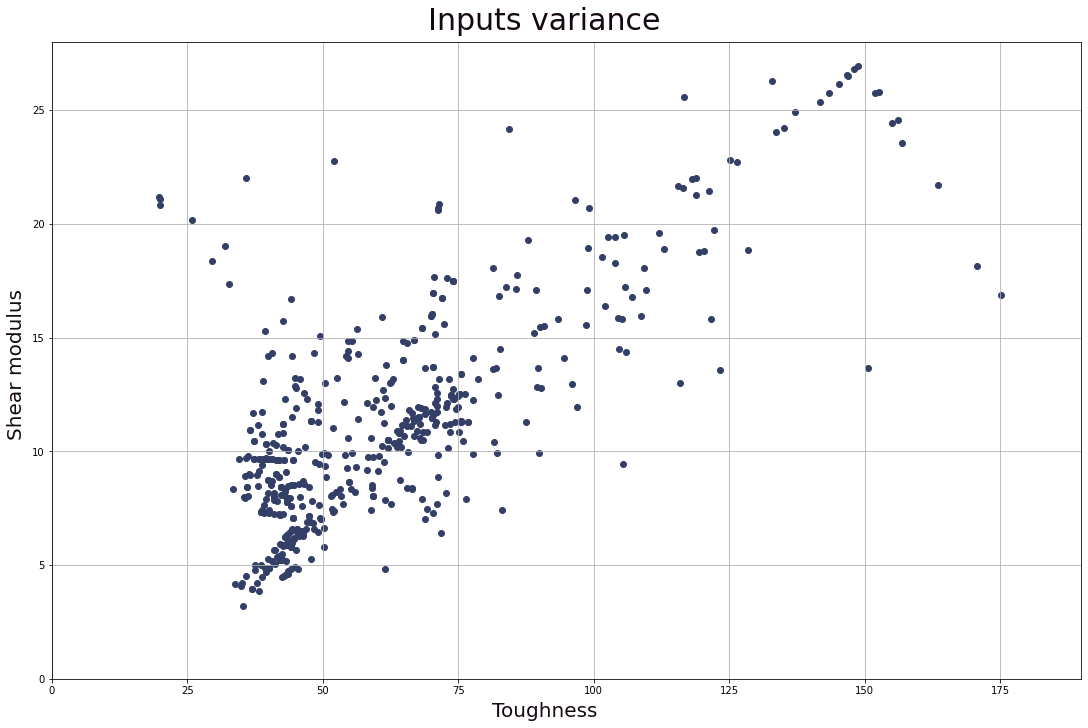

In [13]:
scatter_plot = plotting.input_scatter_plot(properties_values)

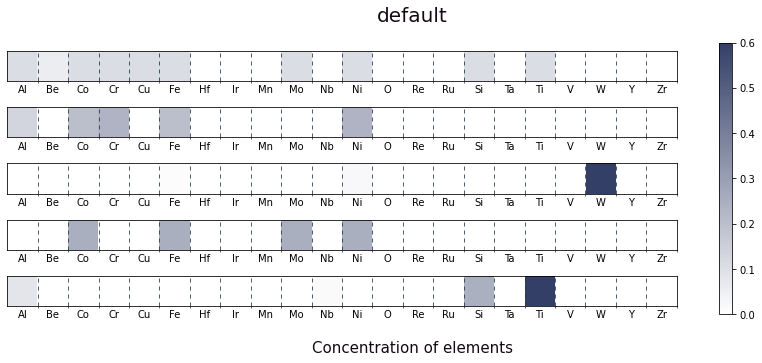

In [7]:
dis_plot = plotting.sample_plot(Training_sequences,dset,interval=10)

## latent space comparision (cAE vs cVAE)

### cAE

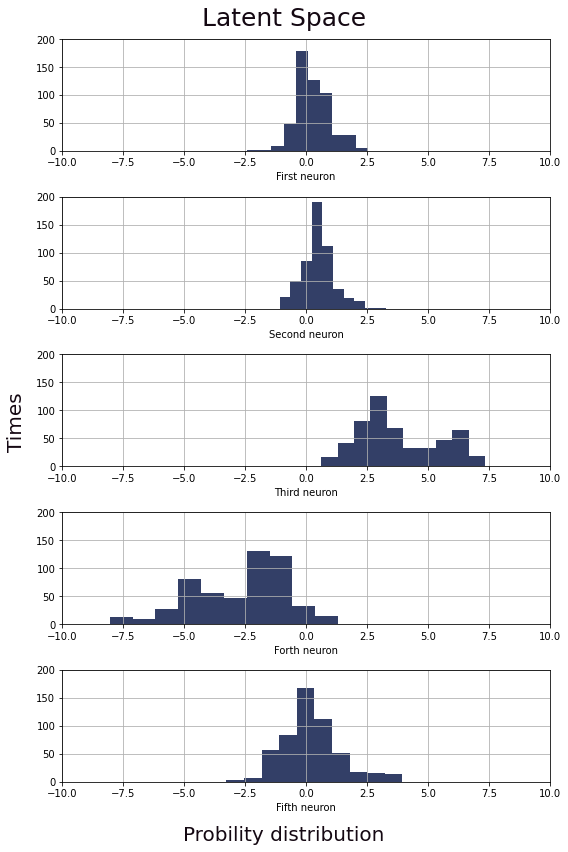

In [7]:
latent_min_Max_collection_cAE,latent_mean_std_collection_cAE,latent_code_cAE=vg.latent_code_inspector_cAE(cAE,Training_sequences,properties_values_scaled)
variance_plot_cAE=plotting.latent_code_variance(latent_code_cAE)

### cVAE

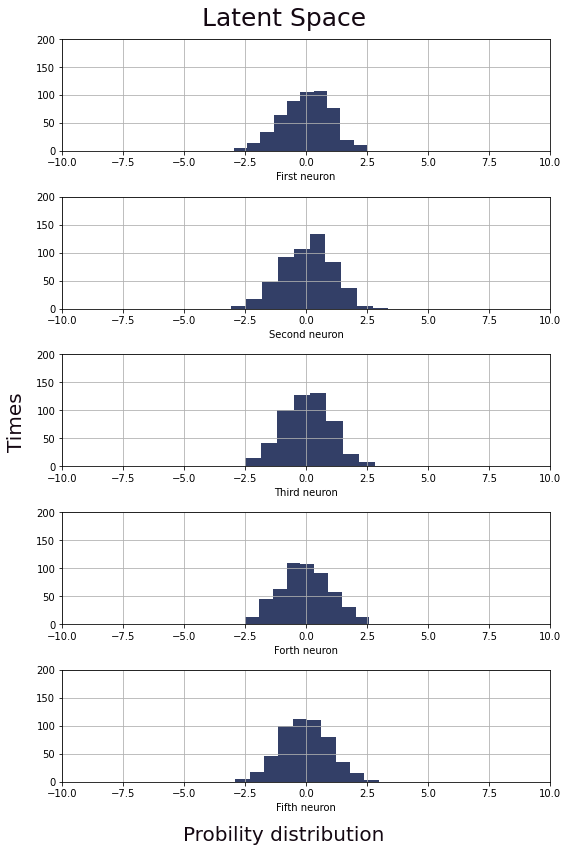

In [8]:
cVAE_min_Max_collection_cVAE,latent_mean_std_collection_cVAE,latent_code_cVAE=vg.latent_code_inspector_cVAE(cVAE,Training_sequences,properties_values_scaled)
variance_plot_cVAE=plotting.latent_code_variance(latent_code_cVAE)

## Mapping plots (cAE vs cVAE vs WcGAN)

### cAE

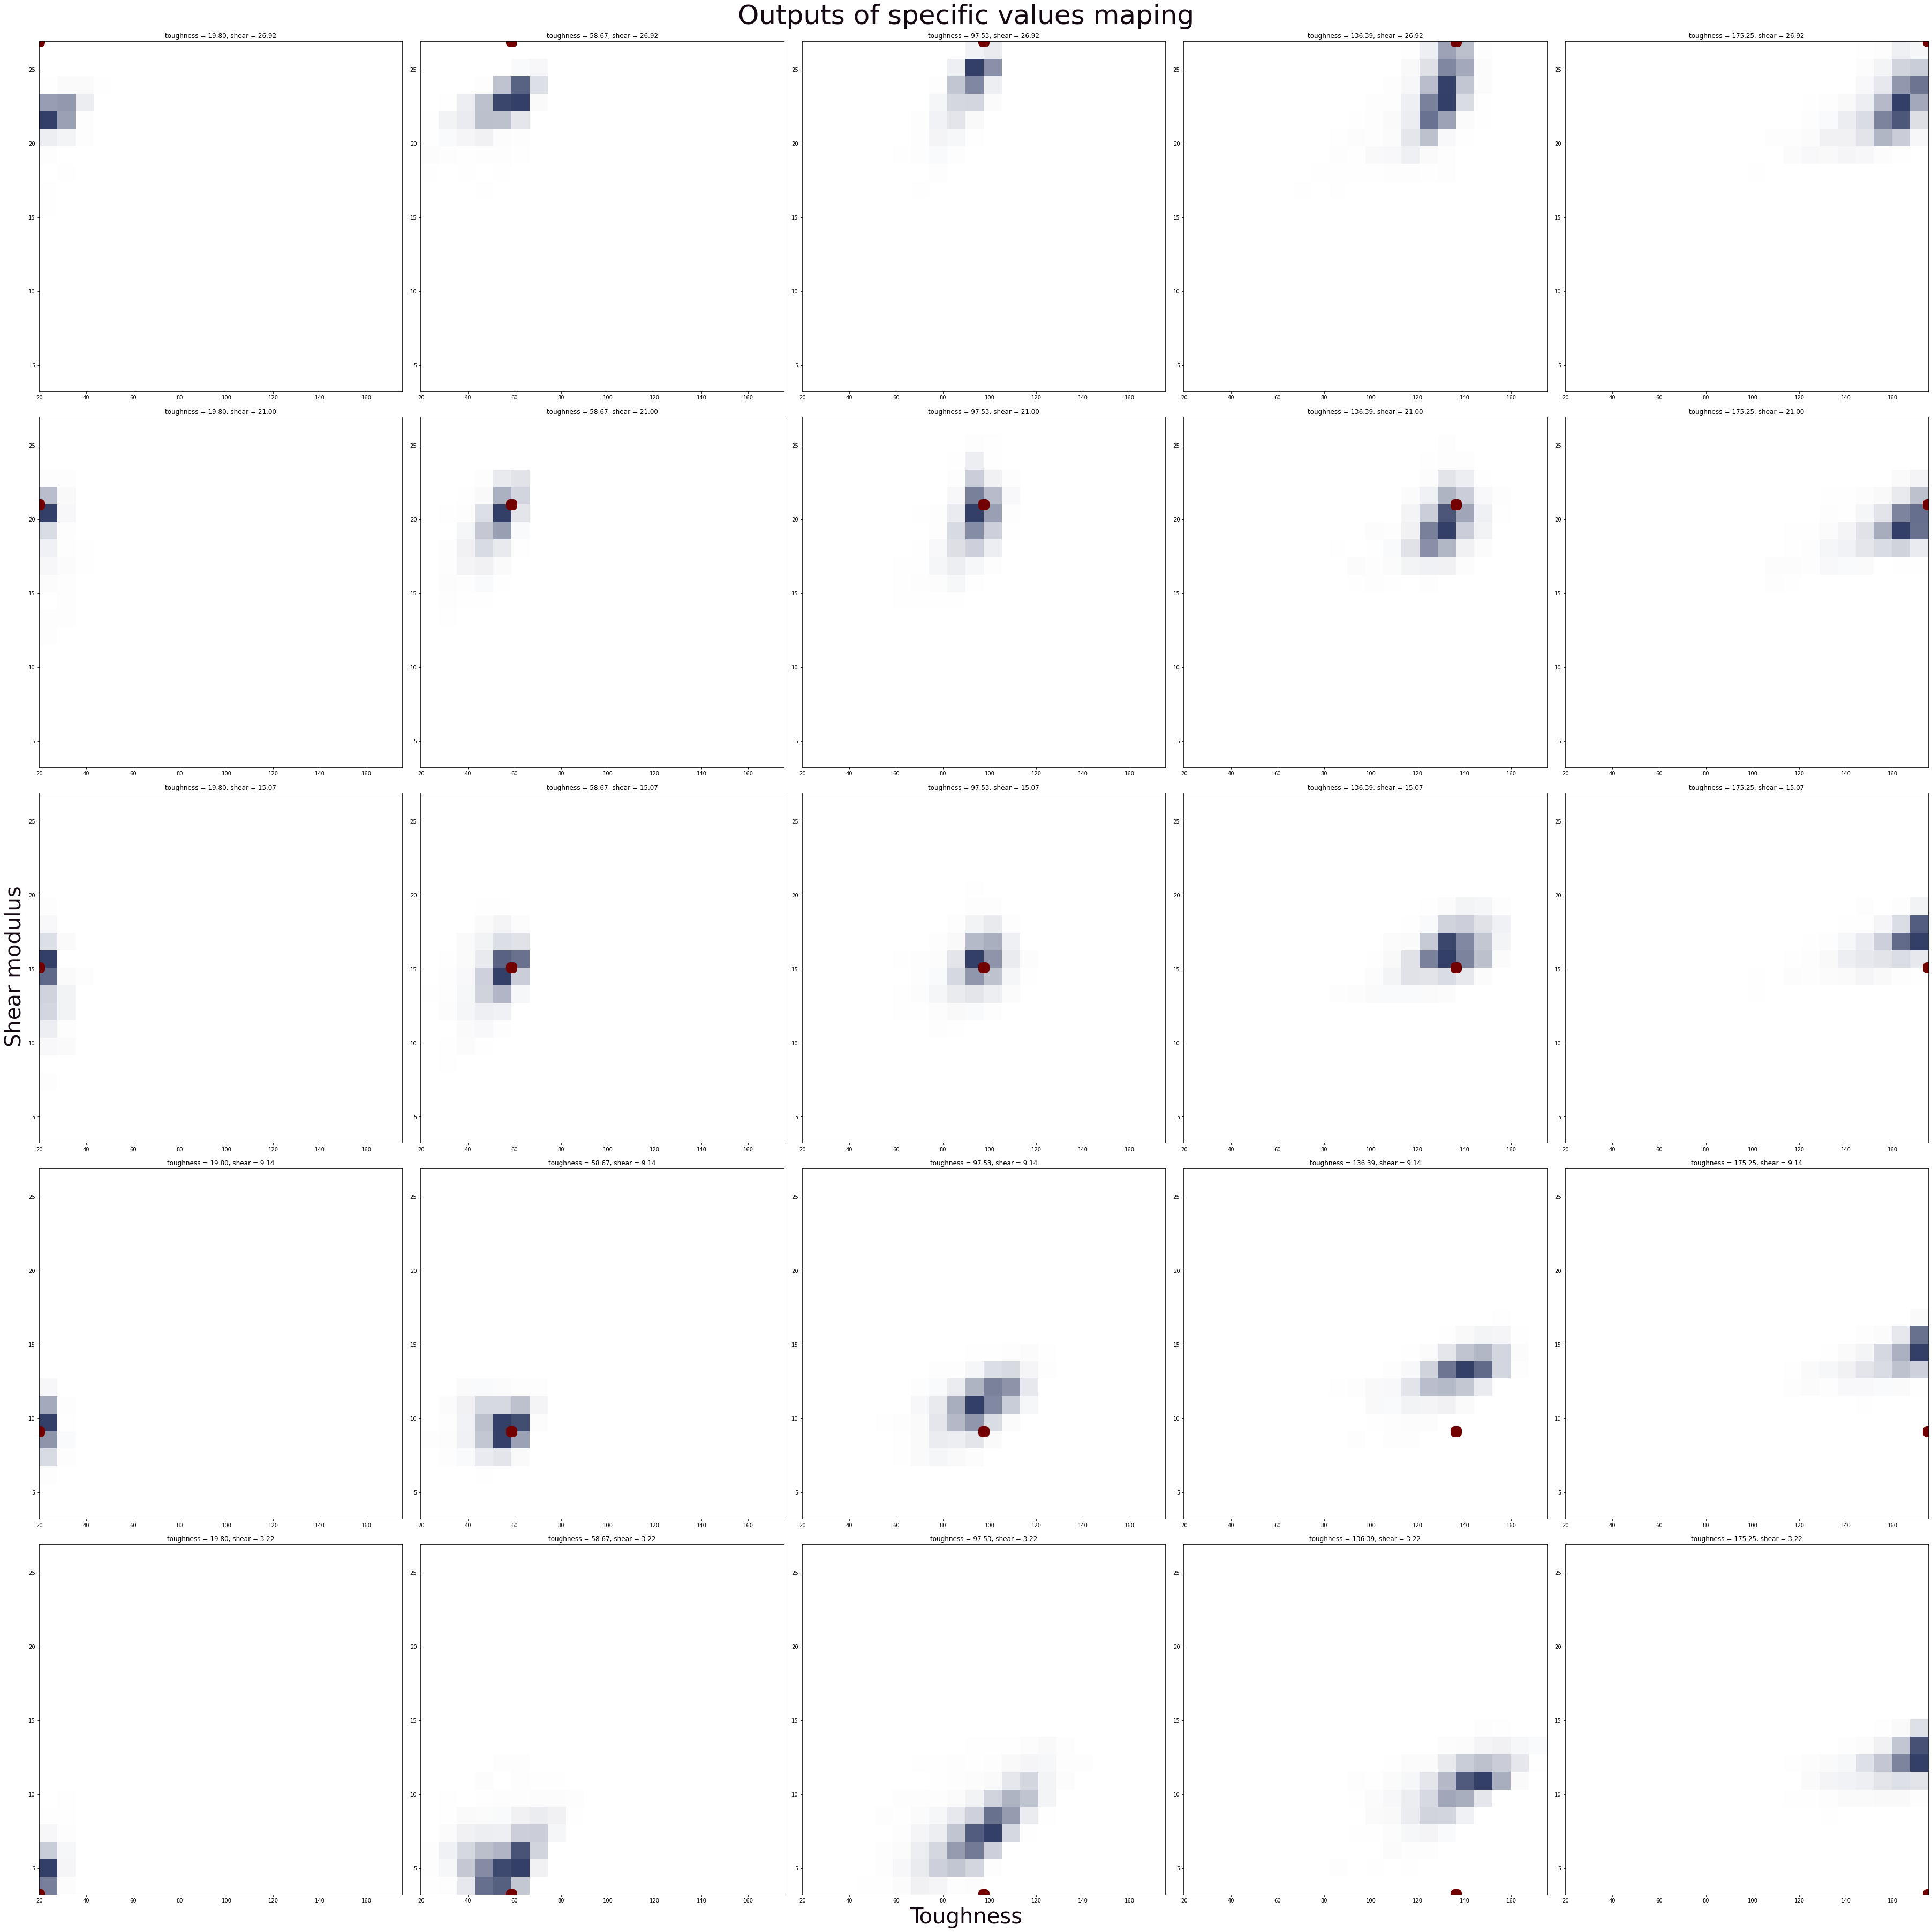

In [9]:
M_cAE_data,M_cAE_conds = vg.preprocess_variance_map_AE(properties_values,latent_mean_std_collection_cAE,scaler,cAE,surrogate_model)
M_cAE =  plotting.variance_map(M_cAE_data,M_cAE_conds)

### cVAE

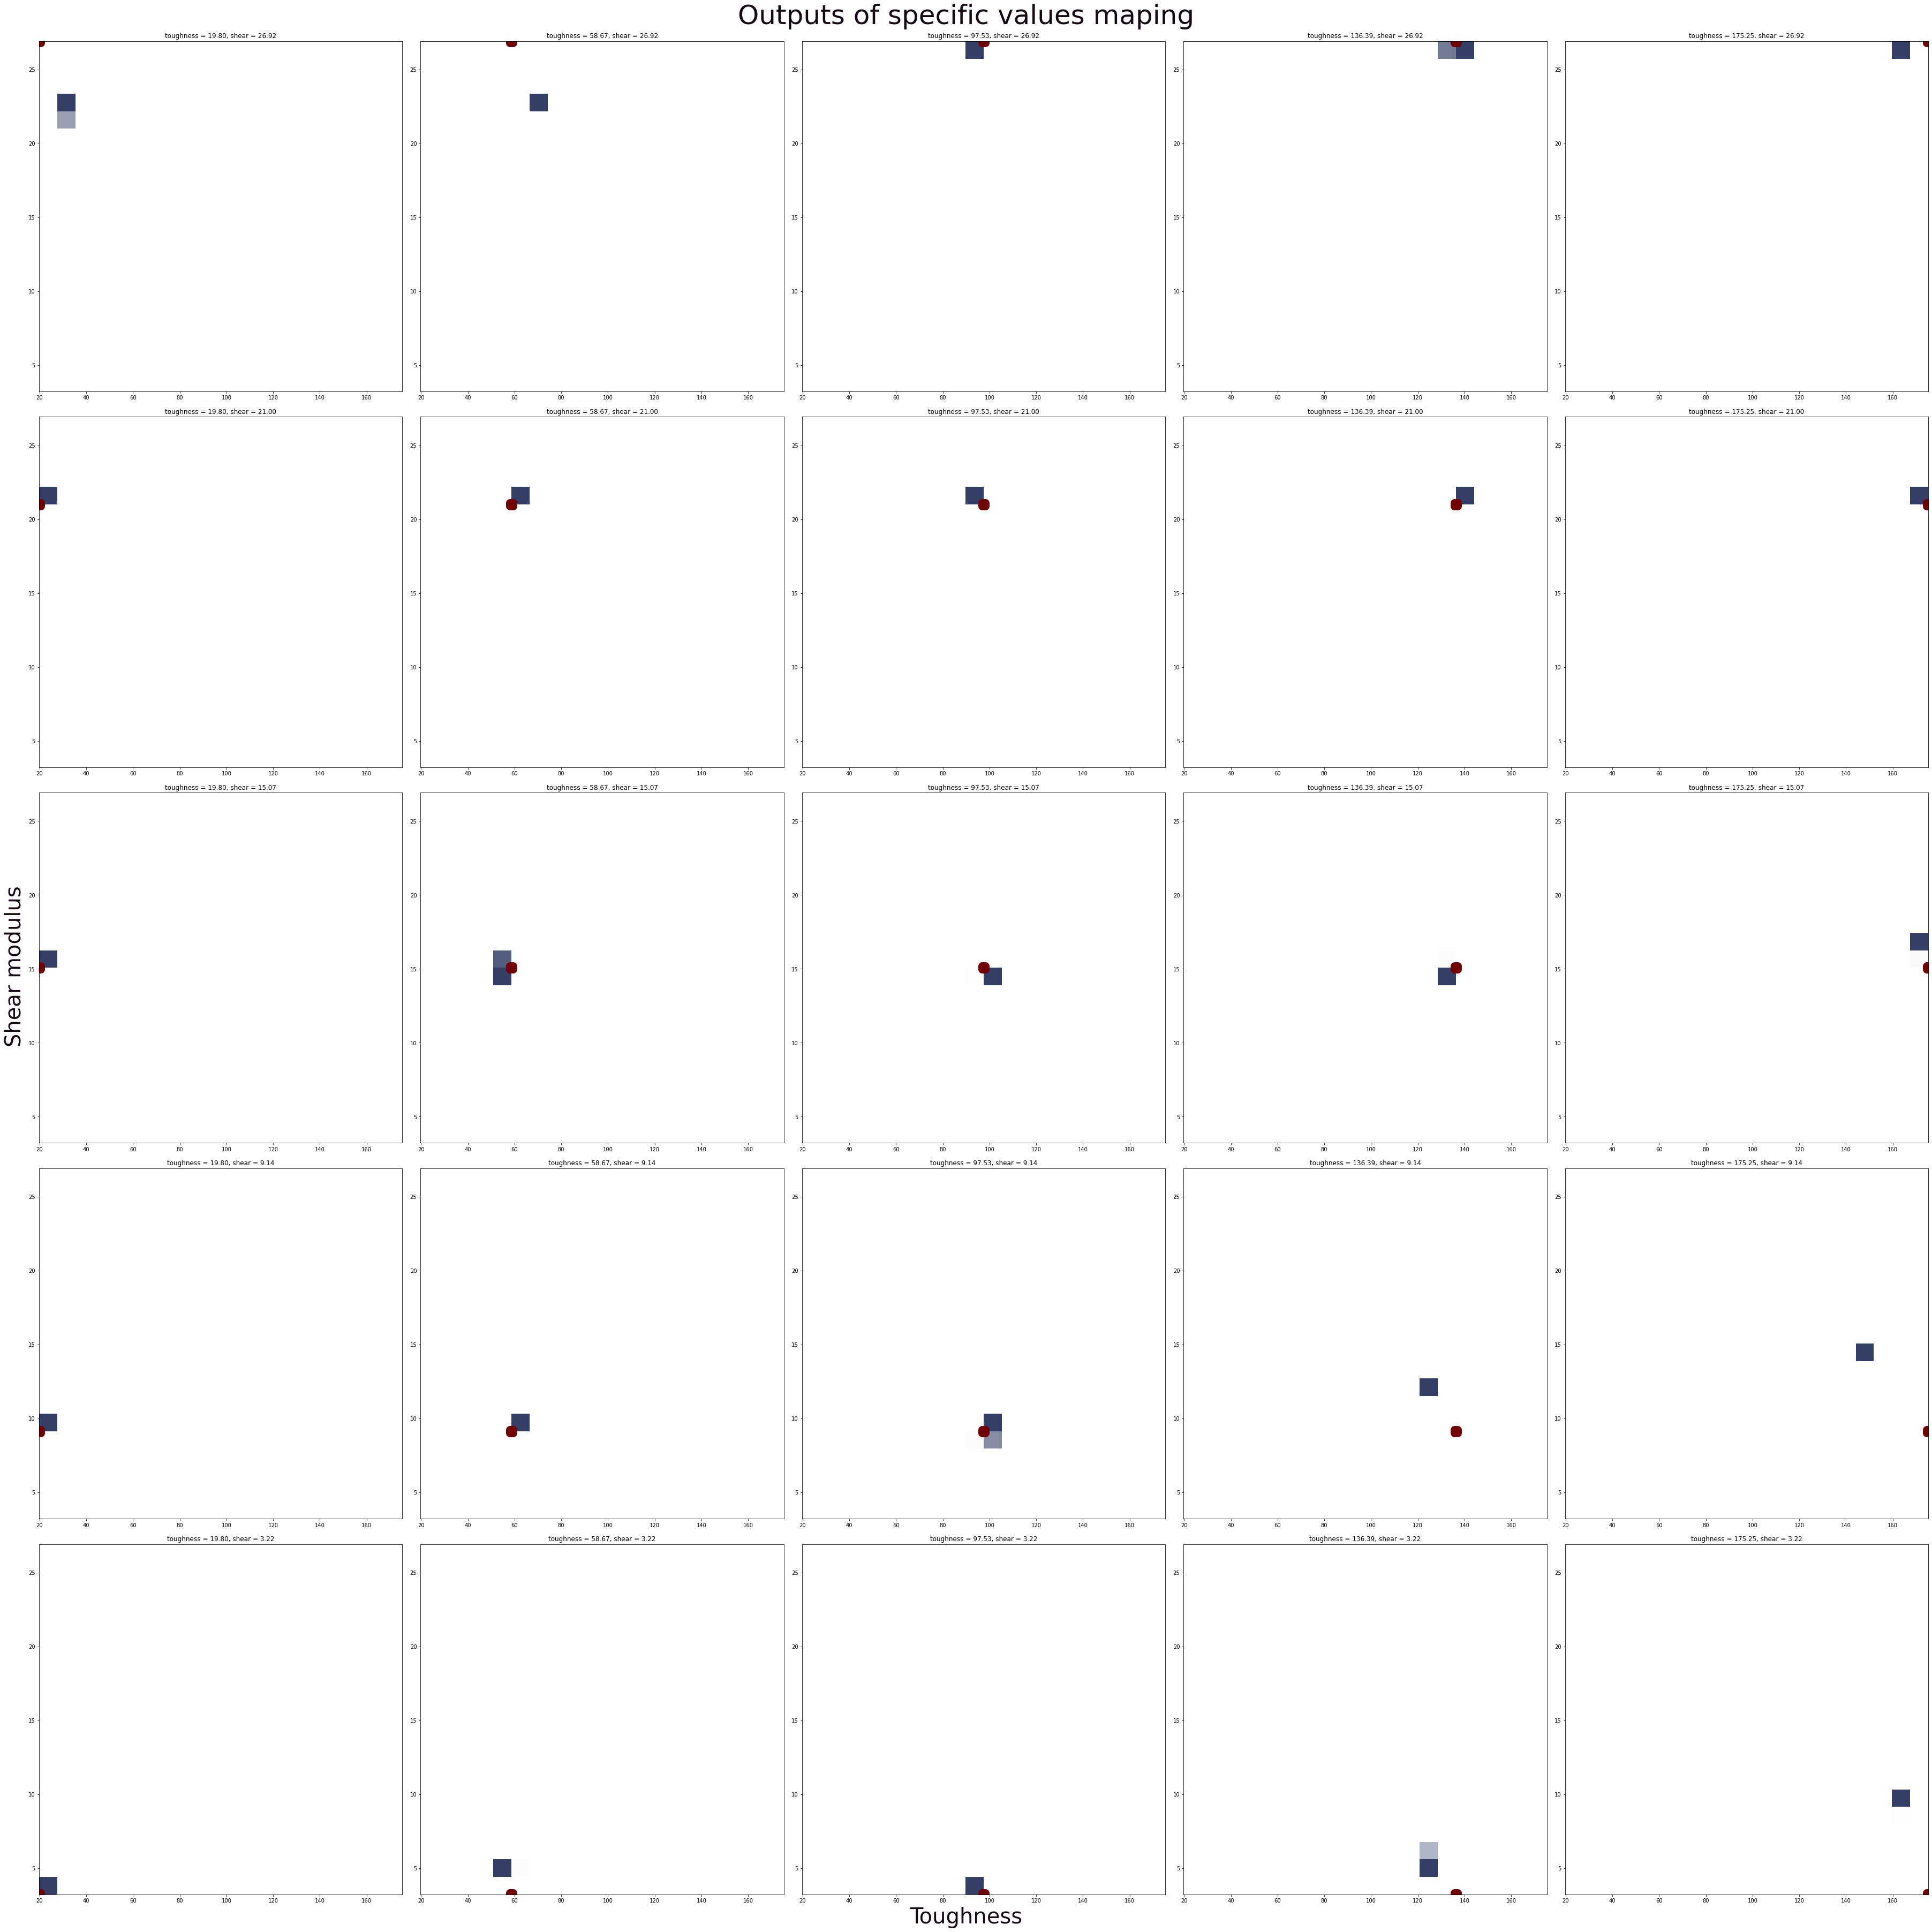

In [10]:
M_cVAE_data,M_cVAE_conds = vg.preprocess_variance_map_AE(properties_values,latent_mean_std_collection_cVAE,scaler,cVAE,surrogate_model)
M_cVAE =  plotting.variance_map(M_cVAE_data,M_cVAE_conds)

### WcGAN

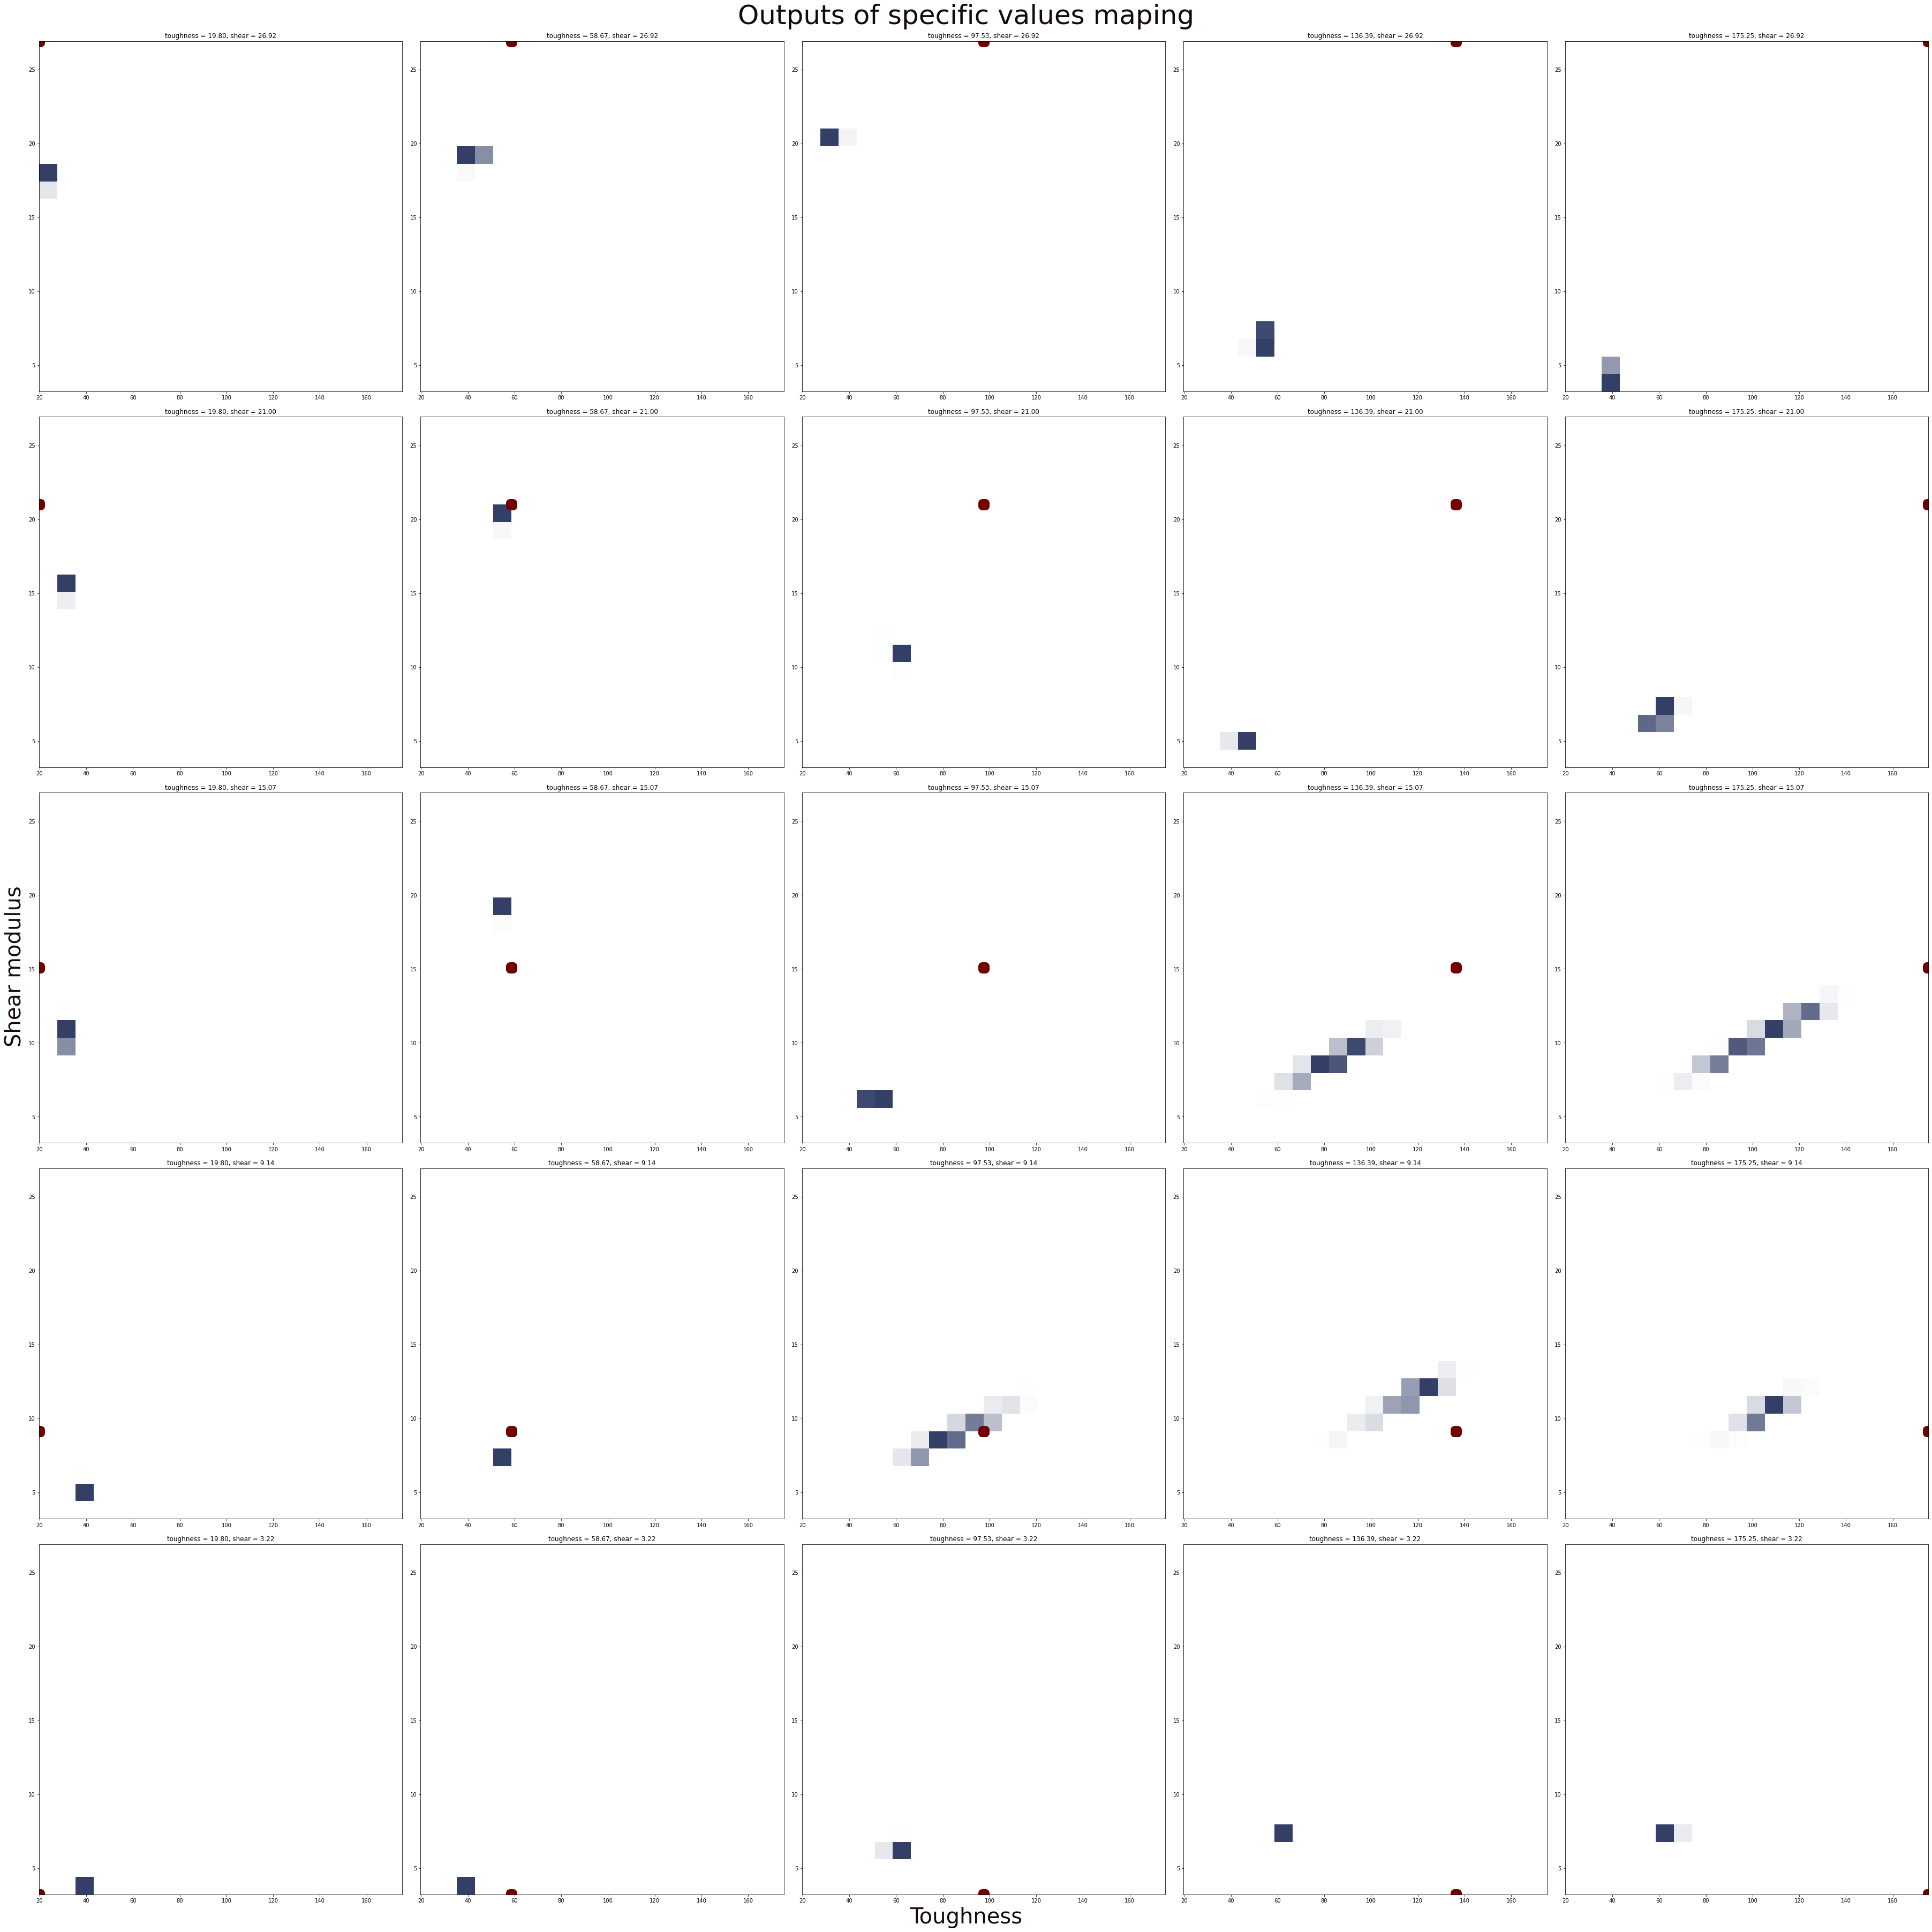

In [17]:
M_GAN_data,M_GAN_conds = vg.preprocess_variance_map_GAN(properties_values,scaler,WcGAN,surrogate_model)
M_GAN = plotting.variance_map(M_GAN_data,M_GAN_conds )

## Violin plots (cAE vs cVAE vs WcGAN)

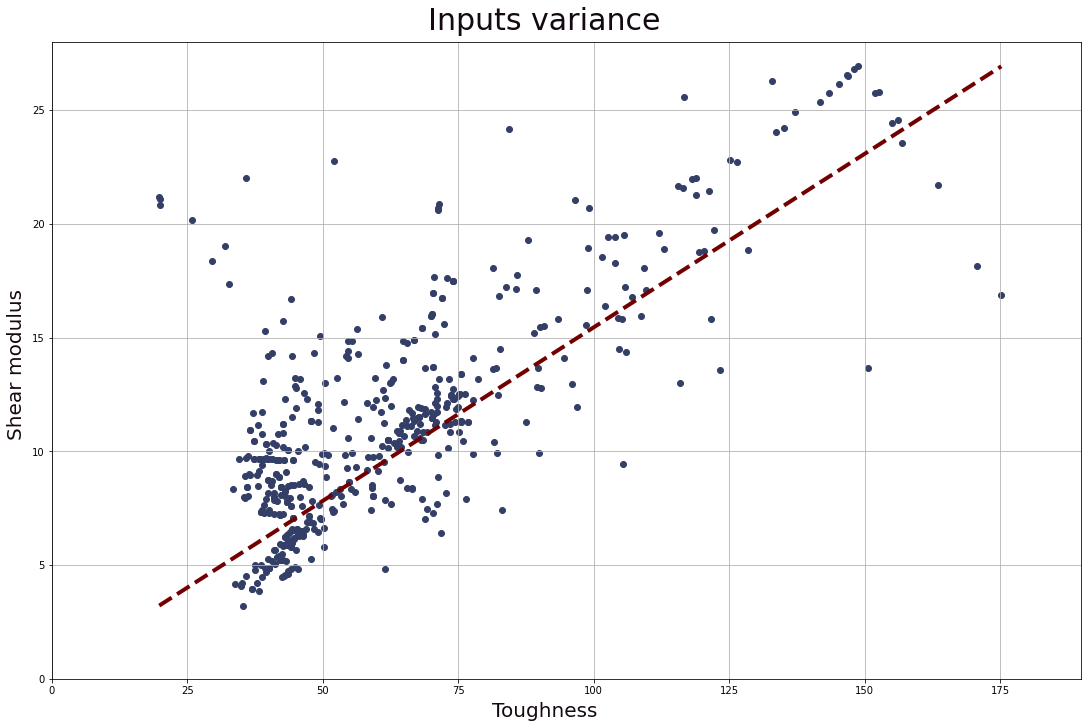

In [13]:
Slice_plot = plotting.input_scatter_plot_slice(properties_values)

### cAE

In [14]:
V_cAE_data,V_cAE_conds = vg.preprocess_violinplot_AE(properties_values,scaler,latent_mean_std_collection_cAE,cAE,surrogate_model)
V_cAE = plotting.violin_plot(V_cAE_data,V_cAE_conds)

### cVAE

In [15]:
V_cVAE_data,V_cVAE_conds = vg.preprocess_violinplot_AE(properties_values,scaler,latent_mean_std_collection_cVAE,cVAE,surrogate_model)
V_cVAE = plotting.violin_plot(V_cVAE_data,V_cVAE_conds)

### WcGAN

In [18]:
V_GAN_data,V_GAN_conds = vg.preprocess_violinplot_GAN(properties_values,scaler,WcGAN,surrogate_model)
V_GAN = plotting.violin_plot(V_GAN_data,V_GAN_conds)

## Random sample (cAE vs cVAE vs WcGAN)

### cAE

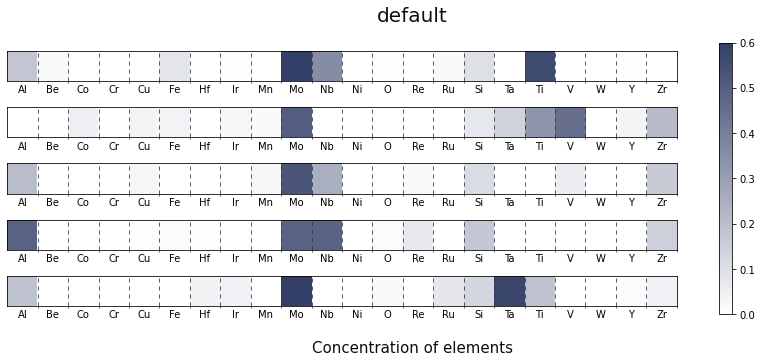

In [13]:
R_cAE_sample,R_cAE_conds = vg.AE_sampler(500,latent_mean_std_collection_cAE,[20,10],scaler,cAE,surrogate_model)
R_cAE = plotting.sample_plot(R_cAE_sample,dset,interval = 10)

### cVAE

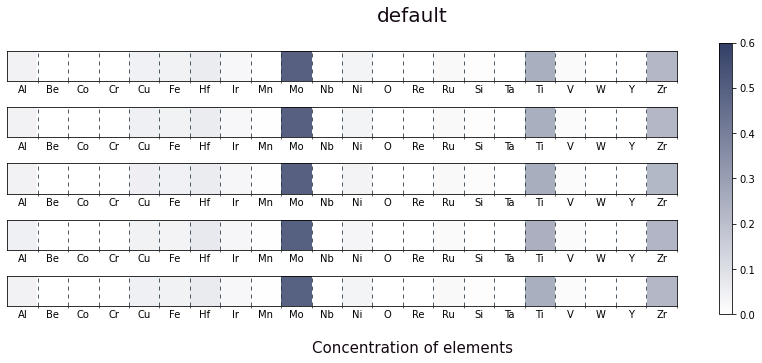

In [14]:
R_cVAE_sample,R_cVAE_conds = vg.AE_sampler(500,latent_mean_std_collection_cVAE,[20,10],scaler,cVAE,surrogate_model)
R_cVAE = plotting.sample_plot(R_cVAE_sample,dset,interval = 10)

### WcGAN

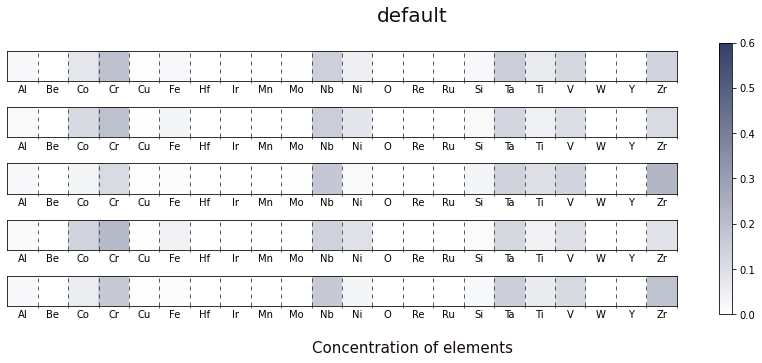

In [27]:
R_cGAN_sample,R_cGAN_conds = vg.g_sample(500,[50,10],WcGAN,surrogate_model,scaler)
R_cGAN = plotting.sample_plot(R_cGAN_sample,dset,interval = 10)

## Interpolation (cAE vs cVAE vs WcGAN)

In [20]:
# def preprocess_interpolation_AE(AE,surrogate_model,scaler,latent_mean_std_collection,toughness,shear,interpolation=5):
#     latent_code = vg.create_latentcode_AE(2,latent_mean_std_collection,latent_dim=5)

#     LATENT = torch.zeros(interpolation,latent_code.shape[1])
#     for i in range(interpolation):
#         LATENT[i] = latent_code[0]+(i+1)*(latent_code[1]-latent_code[0])

#     conds = vg.create_target_ys(interpolation,toughness,shear)
#     conds = scaler.transform(conds)
#     conds = torch.from_numpy(conds).float()
#     Recipes = AE.decode(LATENT,conds)
#     Results = surrogate_model(Recipes)
#     return Recipes.detach().numpy(),Results.detach().numpy()

### cAE

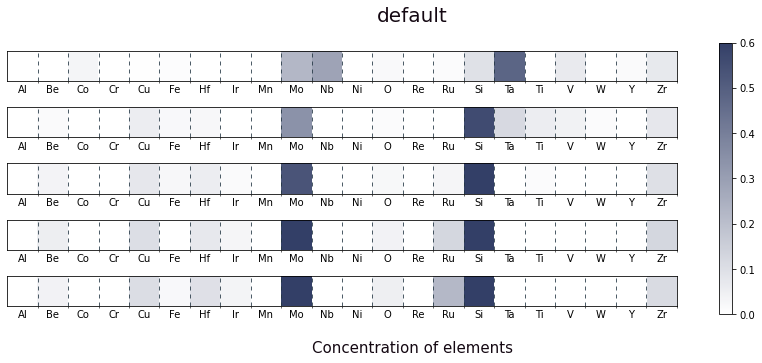

In [24]:
Interpo_cAE_sample,Interpo_cAE_conds=vg.preprocess_interpolation_AE(cAE,surrogate_model,scaler,latent_code_cAE,50,10)
Interpo_cAE = plotting.sample_plot(Interpo_cAE_sample,dset)

### cVAE

In [20]:
Interpo_cVAE_sample,Interpo_cVAE_conds=vg.preprocess_interpolation_AE(cVAE,surrogate_model,scaler,latent_mean_std_collection_cVAE,50,10)
Interpo_cVAE = plotting.sample_plot(Interpo_cVAE_sample,dset)

NameError: name 'vg' is not defined

### WcGAN